https://www.kaggle.com/meli19/surprise-me-h2o-automl-version-ver5-lb-0-479

In [1]:
"""
Contributions from:
DSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) 
https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493
JdPaletto - Surprised Yet? - Part2 - (LB: 0.503)
https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503
hklee - weighted mean comparisons, LB 0.497, 1ST
https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st

Also all comments for changes, encouragement, and forked scripts rock

Keep the Surprise Going
"""

import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor
import h2o
from h2o.automl import H2OAutoML
h2o.init()
%pylab inline

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppEuq1_
  JVM stdout: /tmp/tmppEuq1_/h2o_bo_started_from_python.out
  JVM stderr: /tmp/tmppEuq1_/h2o_bo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster version:        3.16.0.2
H2O cluster version age:    2 months and 1 day
H2O cluster name:           H2O_from_python_bo_pyk1q9
H2O cluster total nodes:    1
H2O cluster free memory:    20.98 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             2.7.14 final
--------------------------  ----------------------------------------

Populating the interactive namespace from numpy and matplotlib


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from __future__ import division

In [54]:
data = {
    'tra': pd.read_csv('../input/air_visit_data.csv'),
    'as': pd.read_csv('../input/air_store_info.csv'),
    'hs': pd.read_csv('../input/hpg_store_info.csv'),
    'ar': pd.read_csv('../input/air_reserve.csv'),
    'hr': pd.read_csv('../input/hpg_reserve.csv'),
    'id': pd.read_csv('../input/store_id_relation.csv'),
    #'tes': pd.read_csv('../input/sample_submission.csv'),
    'hol': pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])


In [55]:
data['tra']['aa']=pd.to_datetime(data['tra']['visit_date'])

In [56]:
tmpdf=data['tra']

In [57]:
SPLIT=tmpdf['aa'].max()-pd.Timedelta(days=39)
SPLIT

Timestamp('2017-03-14 00:00:00')

In [60]:
data['tes']=tmpdf[tmpdf['aa']>SPLIT]
data['tra']=tmpdf[tmpdf['aa']<=SPLIT]

In [61]:
data['tes']['visit_date'].value_counts().shape

(39,)

In [63]:
data['tes']['rawy']=data['tes']['visitors']

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [10]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
# data['tra']['dom'] = data['tra']['visit_date'].dt.day
data['tra']['doy'] = data['tra']['visit_date'].dt.dayofyear
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['week'] = data['tra']['visit_date'].dt.week
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date


#data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
#data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
# data['tes']['dom'] = data['tes']['visit_date'].dt.day
data['tes']['doy'] = data['tes']['visit_date'].dt.dayofyear
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['week'] = data['tes']['visit_date'].dt.week
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [11]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)


In [12]:
stores.shape

(5782, 2)

In [13]:
#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])

In [14]:
# tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
# stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 

In [15]:
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(4):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name' +str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))

stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])


In [17]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date


In [18]:

train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])


In [19]:

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)
test['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

train = train.fillna(-999)
test = test.fillna(-999)

train['visitors'] = np.log1p(train['visitors'].values)

print('Pre-processing done!')


Pre-processing done!


In [42]:
def f(df,col):
    a=df[['visit_date',col]].groupby("visit_date").mean().iloc[:,0]
    a.plot();plt.show()
    return a
def g(df,col,store):
    df=df[df['air_store_id2']==store].copy()
    df.loc[df[col]<0,col]=np.nan
    a=df[['visit_date',col]].groupby("visit_date").mean().iloc[:,0]
    #display(df.dropna())
    if len(a.dropna())>0:
        a.plot();plt.show()
    return a

In [43]:
str([u for u in train.columns])

"['air_store_id', 'visit_date', 'visitors', 'aa', 'dow', 'doy', 'year', 'month', 'week', 'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors', 'count_observations', 'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'air_genre_name0', 'air_area_name0', 'air_genre_name1', 'air_area_name1', 'air_genre_name2', 'air_area_name2', 'air_genre_name3', 'air_area_name3', 'rs1_x', 'rv1_x', 'rs2_x', 'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'id', 'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id2']"

In [44]:
#train[train['total_reserv_mean']>0]

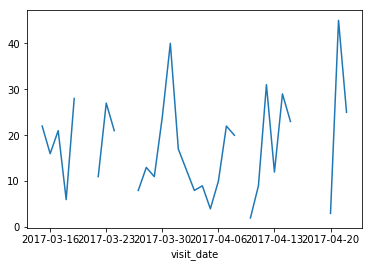

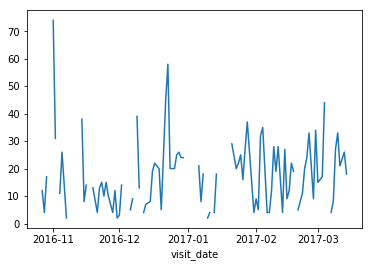

In [48]:
g(test,'rv1_x',187);
g(train,'rv1_x',187);

In [49]:

htrain = h2o.H2OFrame(train)
htest = h2o.H2OFrame(test)

htrain.drop(['id', 'air_store_id', 'visit_date'])
htest.drop(['id', 'air_store_id', 'visit_date'])

x =htrain.columns
y ='visitors'
x.remove(y)

def RMSLE(y_, pred):
    return metrics.mean_squared_error(y_, pred)**0.5



Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [51]:
print('Starting h2o autoML model!')  

aml = H2OAutoML(max_runtime_secs = 3350)
aml.train(x=x, y =y, training_frame=htrain, leaderboard_frame = htest)

print('Generate predictions...')
htrain.drop(['visitors'])
preds = aml.leader.predict(htrain)
preds = preds.as_data_frame()
print('RMSLE H2O automl leader: ', RMSLE(train['visitors'].values, preds))

preds = aml.leader.predict(htest)
preds = preds.as_data_frame()

test['visitors'] = preds
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
#del train; del data; del htrain; del htest;

Starting h2o autoML model!
AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Generate predictions...
gbm prediction progress: |████████████████████████████████████████████████| 100%
('RMSLE H2O automl leader: ', 0.45291097777119305)
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [82]:
test2=test.copy()
for u in [ u'rs1_x', u'rv1_x', u'rs2_x',
       u'rv2_x', u'rs1_y', u'rv1_y', u'rs2_y', u'rv2_y', 
       u'total_reserv_sum', u'total_reserv_mean', u'total_reserv_dt_diff_mean']:
    test2[u]=-999

In [84]:
htest2 = h2o.H2OFrame(test2)
htest2.drop(['id', 'air_store_id', 'visit_date']);


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [88]:
preds2 = aml.leader.predict(htest2)
preds2 = preds2.as_data_frame()

test2['visitors'] = preds2
test2['visitors'] = np.expm1(test2['visitors']).clip(lower=0.)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [89]:
newtest=pd.merge(test,data['tes'], on = ['air_store_id','aa'])
newtest2=pd.merge(test2,data['tes'], on = ['air_store_id','aa'])

In [71]:
from sklearn.metrics import mean_squared_error

In [90]:
mean_squared_error(np.log1p(newtest['rawy']),np.log1p(newtest['visitors_x'])),\
mean_squared_error(np.log1p(newtest2['rawy']),np.log1p(newtest2['visitors_x']))

(0.26272932025418994, 0.30657020862083534)

In [96]:
lst=[]
lst2=[]
for d in sorted(list(set(newtest['aa']))):
    subdf=newtest[newtest['aa']==d]
    subdf2=newtest2[newtest2['aa']==d]    
    lst.append(mean_squared_error(np.log1p(subdf['rawy']),np.log1p(subdf['visitors_x'])))
    lst2.append(mean_squared_error(np.log1p(subdf2['rawy']),np.log1p(subdf2['visitors_x'])))    
    print d.date(), lst[-1],lst2[-1]
print np.mean(lst),np.mean(lst2)

2017-03-15 0.242472081629 0.281422211216
2017-03-16 0.236120542792 0.277459244681
2017-03-17 0.193938620711 0.233625874937
2017-03-18 0.212331517918 0.245998172954
2017-03-19 0.296167875849 0.416869951418
2017-03-20 0.314285274759 0.368416015428
2017-03-21 0.34836595553 0.389310880001
2017-03-22 0.248197518063 0.311497186539
2017-03-23 0.234258675325 0.291903144784
2017-03-24 0.202770015083 0.265670817236
2017-03-25 0.226294197277 0.26967584066
2017-03-26 0.308087269338 0.348983778149
2017-03-27 0.283112378654 0.358905248492
2017-03-28 0.278149315195 0.34591531178
2017-03-29 0.231977224155 0.31456416338
2017-03-30 0.245265446844 0.303985736121
2017-03-31 0.248063525991 0.285584191606
2017-04-01 0.257655008318 0.277653054546
2017-04-02 0.331752746409 0.354821436392
2017-04-03 0.296730015879 0.345390093183
2017-04-04 0.303255740037 0.349271437386
2017-04-05 0.26775484902 0.305313320561
2017-04-06 0.295235424626 0.326681386309
2017-04-07 0.26104090855 0.291785133407
2017-04-08 0.240158436